# Quantum Classfier

In [9]:
#%pip install qiskit qiskit_machine_learning
#%pip install ucimlrepo
#%pip install torch
#%pip install matplotlib
#%pip install pylatexenc

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136897 sha256=5cae5265e0de06c79e3a3cb30ab05f2014af9458a6ff8c2106039d7ef657015d
  Stored in directory: /Users/jkw/Library/Caches/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
Note: you may need to restart the kernel to use updated packages.


In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
# from qiskit.primitives import StatevectorEstimator
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
import sys          # Standard library module for system-specific parameters and functions
import subprocess   # Standard library module for spawning new processes
from sklearn.preprocessing import MinMaxScaler # Importuje MinMaxScaler do skalowania danych
from sklearn.model_selection import train_test_split # Importuje train_test_split do podziału danych
from ucimlrepo import fetch_ucirepo     # Importuje fetch_ucirepo do pobierania zestawów danych z UCI ML Repository
from sklearn.utils import shuffle
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score


In [2]:

def ensure_package(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        __import__(import_name)
    except ImportError:
        print(f'Instalowanie {pkg_name}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])
        print(f'Zakończono instalację {pkg_name}')
    except Exception as e:
        print(f"Wystąpił nieoczekiwany błąd podczas sprawdzania pakietu {pkg_name}: {e}")


ensure_package('numpy')
ensure_package('scikit-learn', 'sklearn')
ensure_package('ucimlrepo')



# Funkcja przygotowująca dane
def prepare_data():

    # Pobiera zestaw danych 'banknote authentication' z UCI ML Repository
    banknote_authentication = fetch_ucirepo(id=267)
    # Wyodrębnia cechy (zmienne niezależne) z zestawu danych
    X = banknote_authentication.data.features
    # Wyodrębnia zmienną docelową (zmienna zależna) z zestawu danych
    y = banknote_authentication.data.targets

    X = X.to_numpy() # Konwertuje cechy na tablicę NumPy
    y = y.to_numpy().ravel() # Konwertuje zmienną docelową na spłaszczoną tablicę NumPy

    # Dzieli dane na zestawy treningowe i testowe
    # test_size=0.2 oznacza 20% danych dla testowania, random_state zapewnia powtarzalność podziału
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Skalowanie danych
    # Inicjalizuje MinMaxScaler, który skaluje cechy do zakresu od 0 do pi
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    # Dopasowuje skaler do danych treningowych i jednocześnie je skaluje
    # 'fit_transform' jest używane na danych treningowych, aby skaler nauczył się min/max wartości
    X_train_scaled = scaler.fit_transform(X_train)
    # Skaluje dane testowe przy użyciu parametrów nauczonych z danych treningowych
    # 'transform' jest używane na danych testowych, aby uniknąć wycieku danych
    X_test_scaled = scaler.transform(X_test)

    # Zwraca przygotowane i przeskalowane dane
    return X_train_scaled, X_test_scaled, y_train, y_test

# Uruchamia funkcję prepare_data() tylko wtedy, gdy skrypt jest wykonywany bezpośrednio
if __name__ == "__main__":
    # Wywołuje funkcję przygotowującą dane i przypisuje zwrócone wartości do zmiennych
    X_tr, X_te, y_tr, y_te = prepare_data()
    print("test") # Wypisuje "test" do konsoli, sygnalizując zakończenie operacji

test


Poniższy kod odpowiada za anstaz. Powstał on w oparciu o bibliteke Qiskit i korzysta z wbudowanych w nią funkcji, takich jak ParameterVektor służący do łatwego iterowania po parametrach bramek rotacyjnych. Sieć zakładay wykożystanie 4 qbitów oraz parzystej ilości warst. Każda warstwa składa się za podwarstwy niezależnych bramek oraz podwarstwy splątania.


Indeksy tych parametrów są numerowane od zera, a konstrukcja " j*n_qubits * 4 " upewnia się, że każda warstwa kożysta jedynie ze swoich parametrów.

In [3]:
def ansatz(n_qubits, depth):

    #Stworzenie parametrów bramek rotacyjnych
    theta = ParameterVector('θ', 8*depth)

    #Inicjalizacja układu
    qc = QuantumCircuit(n_qubits)

    #Pętla warst
    for j in range(depth//2):

        #Warstwa 1/3(0-7)(16-23)
        for i in range(n_qubits):
            qc.ry(theta[j*n_qubits*4+i], i)
        #Bariera upewnia się, że obliczeina zostaną wykonane liniowo, a nie skompresowane
        qc.barrier()

        qc.crx(theta[j*n_qubits*4+4], 3, 0)
        qc.crx(theta[j*n_qubits*4+5], 2, 3)
        qc.crx(theta[j*n_qubits*4+6], 1, 2)
        qc.crx(theta[j*n_qubits*4+7], 0, 1)
        qc.barrier()

        #Warstwa 2/4(8-15)(25-31)
        for i in range(n_qubits):
            qc.rx(theta[j*n_qubits*4+8 + i], i)
        qc.barrier()

        qc.cry(theta[j*n_qubits*4+12], 3, 2)
        qc.cry(theta[j*n_qubits*4+13], 0, 3)
        qc.cry(theta[j*n_qubits*4+14], 1, 0)
        qc.cry(theta[j*n_qubits*4+15], 2, 1)
        qc.barrier()

    qc.cx(3, 2)
    qc.cx(2, 1)
    qc.cx(1, 0)

    return qc



In [5]:

class HybridModel:
    def __init__(self, ansatz_circuit, num_qubits):

        # we inicialize the variables
        self.num_qubits = num_qubits

        '''now we perform data encoding using ZZFetureMap, briefly it consist of three layers
        1. hadamard - puts all the qubits in superposition state |+>
        2. Z-Rotations - rotates each qubit individually based on input features Rz(x)
        3. ZZ-Rotations - it entangles qubits by rotating them based on the relationship between two features

        reps=1, we do the circuit of encoding only once. We can try and change that to 2 but it gets deeper
        '''
        self.feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)

        # Initalizing quantum circuit. Here we are connecting our feature map (data) and ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map,qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)


        '''
        So that is a crucial step. Firstly, we inicialize parameters. Our quantum model cannot tell whether the number came from ansatz or feature.
        That is why here we sort them into two lists. If the number came from feature_map, then it will be a feature and the other way around.

        '''
        final_circuit_params = self.qc.parameters

        # creating dicts with names of the variables to then check them in our loop
        feature_map_names = {p.name for p in self.feature_map.parameters}
        ansatz_names = {p.name for p in ansatz_circuit.parameters}

        self.final_input_params = []
        self.final_weight_params = []

        for p in final_circuit_params:
            if p.name in feature_map_names:
                self.final_input_params.append(p)
            elif p.name in ansatz_names:
                self.final_weight_params.append(p)

        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        '''Estimator takes ansatz, observables and parameters (data and weights), returns the Expectation value.'''


        # estimator = StatevectorEstimator()
        estimator = Estimator()
        # creating a gradient for backward
        gradient = ParamShiftEstimatorGradient(estimator)
        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=self.final_input_params,
            weight_params=self.final_weight_params,
            estimator=estimator,
            gradient = gradient
        )


    # forward: gives the Estimator data and weights, sets the qubit angles, runs gates and measures the result
    def forward(self, x, weights):
        return self.qnn.forward(x, weights)

    # backward In Quantum ML it actually runs forward once again but with a little change
    # Firstly it shifts the angles by pi/2 and runs the circuit, then -pi/2 and runs the circuit
    # It calculates the difference and it's the gradient, we only return weight_grads because we dont need input_grads
    def backward(self, x, weights):
        _, weight_grads = self.qnn.backward(x, weights)
        if weight_grads is None:
            # If it fails, return zeros to prevent the loop from crashing
            print("Warning: Gradients were None. Returning Zeros.")
            return np.zeros((x.shape[0], len(weights)))
        return weight_grads


Weights initialized. Shape: (48,)


/var/folders/32/tqw55h7123s28fl1ph38d1xh0000gp/T/ipykernel_37942/1327229255.py:48: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/var/folders/32/tqw55h7123s28fl1ph38d1xh0000gp/T/ipykernel_37942/1327229255.py:50: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  gradient = ParamShiftEstimatorGradient(estimator)
/var/folders/32/tqw55h7123s28fl1ph38d1xh0000gp/T/ipykernel_37942/1327229255.py:51: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed n

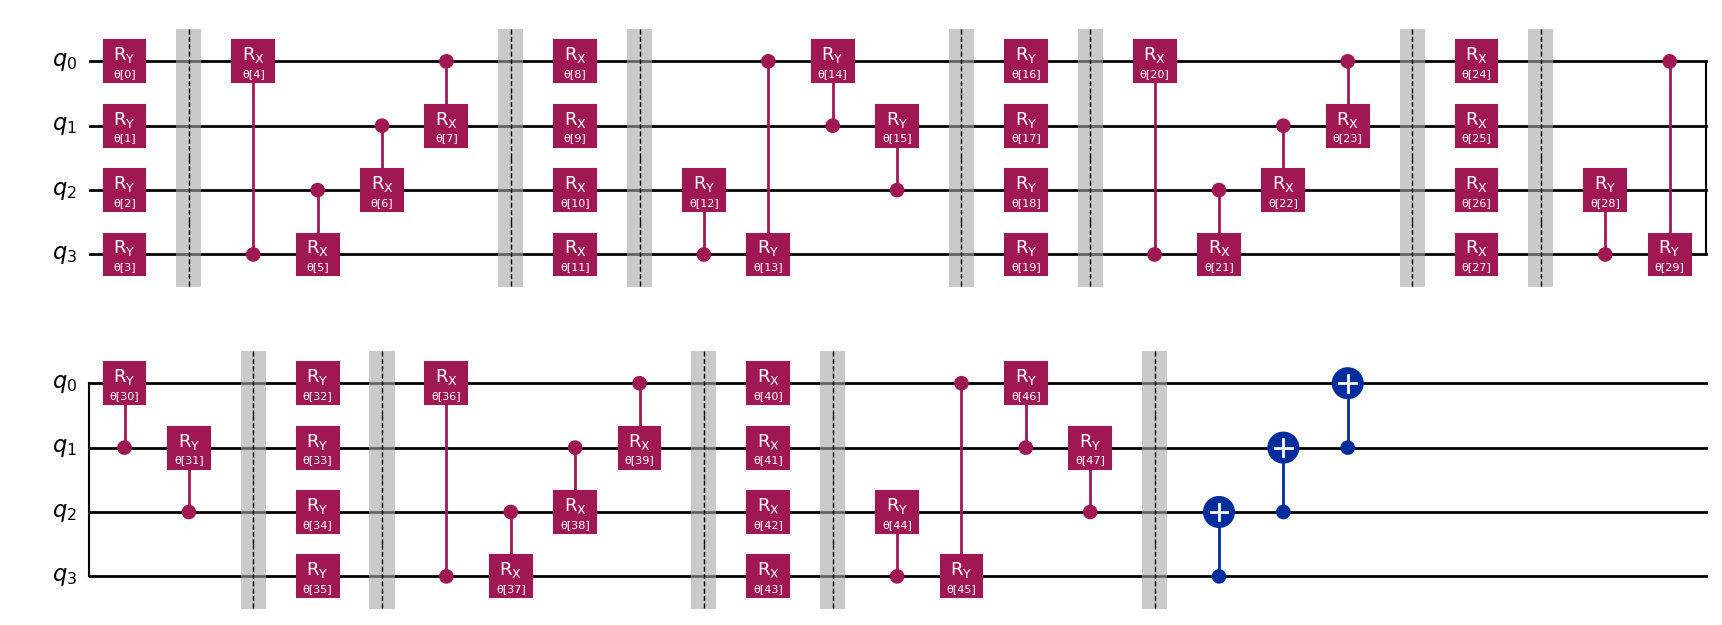

In [6]:
my_ansatz = ansatz(4, 6)
qnn = HybridModel(
    ansatz_circuit=my_ansatz,
    num_qubits=4,
)


# Inicializing the weights
num_weights = qnn.qnn.num_weights
rng = np.random.default_rng(seed=42)
weights = 2 * np.pi * rng.random(num_weights)
weights = weights.flatten()

print(f"Weights initialized. Shape: {weights.shape}")
my_ansatz.draw(output='mpl')

In [8]:
EPOCHS = 40 
BATCH_SIZE = 64
LEARNING_RATE = 0.02

train_loss_history = []
test_loss_history = []
acc_history = []

print("Pobieranie danych z funkcji prepare_data()...")

# Zwraca ona już przeskalowane cechy "X" w zakresie [0, pi], więc z X nie musimy juz nic robic.
X_train, X_test, y_train_raw, y_test_raw = prepare_data()

# Funkcja prepare_data zwraca etykiety {0, 1}.
# Nasz model HybridModel używa pomiaru Z (wartości od -1 do 1).
# Konwertujemy: 0 -> -1 oraz 1 -> 1
y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

# Upewniamy się, że typy danych to float32 (najlepsze dla PyTorch/NumPy)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"Dane gotowe. Liczba próbek treningowych: {len(X_train)}")

Pobieranie danych z funkcji prepare_data()...
Dane gotowe. Liczba próbek treningowych: 1097


In [ ]:
# PRZYGOTOWANIE OPTYMALIZATORA ADAM
# Tworzymy Tensor PyTorcha, który będzie przechowywał wagi i historię gradientów
weights_tensor = torch.tensor(weights, requires_grad=True, dtype=torch.float32)

# Używamy adam optimizer
optimizer = torch.optim.Adam([weights_tensor], lr=LEARNING_RATE)

print(f"Start treningu... Model: HybridModel, Epoki: {EPOCHS}, LR: {LEARNING_RATE}")# GŁÓWNA PĘTLA TRENINGOWA
for epoch in range(EPOCHS):
    # Tasowanie danych w każdej epoce
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=epoch)
    
    epoch_loss = 0.0
    batches_count = 0
    
    # Iteracja po batchach
    for i in range(0, len(X_train), BATCH_SIZE):
        X_batch = X_train_shuffled[i:i + BATCH_SIZE]
        y_batch = y_train_shuffled[i:i + BATCH_SIZE]

        # Konwersja wag na NumPy dla Qiskita (bo Qiskit nie przyjmuje tensorów PyTorcha)
        current_weights_numpy = weights_tensor.detach().numpy()

        # forward
        # Predykcja modelu (zwraca wartości od -1 do 1)
        pred = qnn.forward(X_batch, current_weights_numpy)
        
        # backward
        # Obliczenie gradientów wag (zwraca numpy array)
        grads_numpy = qnn.backward(X_batch, current_weights_numpy)

        # MSE
        # Różnica: predykcja - prawda
        # Reshape tylko dla y_batch, bo pred wychodząc z QNN jest juz w kształcie (32,1)
        # Reshape od flatten rozni się tym ze flatten spłaszcza wszystko do jednego wymiaru i towrzy prostą listę liczb np. [1,2,3] 
        # reshape(-1,1) natomiast układa te same liczby w pionową kolumnę np. [[1], [2], [3]], reshape(3,1)- 3 wiersze i 1 kolumna 
        # reshape(-1,1) -1 oznacza ze bedzie 1 kolumna i parametr -1 zamienia sie automatycznie w BATCH_SIZE czyli 32
        diff = pred - y_batch.reshape(-1, 1)
        loss = np.mean(diff ** 2)
        
        # Chain Rule: pochodna MSE = 2 * (pred - y)
        # 2 * diff bo to pochodna z (pred - y)^2
        grad_modifier = 2 * diff
        
        # OBLICZANIE GRADIENTU
        # Usuwamy zbędny środkowy wymiar (z (32, 1, wagi) na (32, wagi))
        # Dzięki temu mamy prostą macierz: wiersz = próbka, kolumna = gradient wagi
        grads_2d = grads_numpy.reshape(grads_numpy.shape[0], -1)
        
        # Ważymy gradienty (Chain Rule)
        # Każdy wiersz gradientów mnożymy przez błąd danej próbki (grad_modifier)
        weighted_grads = grad_modifier * grads_2d
        
        # Obliczamy średnią po całym batchu (axis=0 to wiersze)
        # To daje nam jeden wektor gradientów do aktualizacji wag
        batch_grads_numpy = np.mean(weighted_grads, axis=0)
        
        # AKTUALIZACJA WAG
        # Czyścimy stare gradienty
        optimizer.zero_grad()
        
        # Dajemy nasz ręcznie policzony gradient do tensora PyTorcha
        weights_tensor.grad = torch.from_numpy(batch_grads_numpy).float()
        
        optimizer.step()
        
        epoch_loss += loss
        batches_count += 1

    # Zapisanie wytrenowanych wag z powrotem do zmiennej numpy
    weights = weights_tensor.detach().numpy()
    
    test_outputs = qnn.forward(X_test, weights)
    test_diff = test_outputs - y_test.reshape(-1, 1)
    test_loss = np.mean(test_diff ** 2)

    # zamiast predicted = (test_outputs > 0.5).astype(int).flatten()
    # bo nasze etykiety y_test to [-1, 1] a nie [0, 1] 
    # Używamy np.where: jeśli wynik > 0 to klasa 1, w przeciwnym razie klasa -1.
    predicted = np.where(test_outputs > 0, 1, -1).flatten()

    test_accuracy = np.mean(predicted == y_test.flatten())

    avg_loss = epoch_loss / batches_count
    train_loss_history.append(avg_loss)
    test_loss_history.append(test_loss)
    acc_history.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Avg loss: {avg_loss:.4f} | Test Acc: {test_accuracy:.4f}")

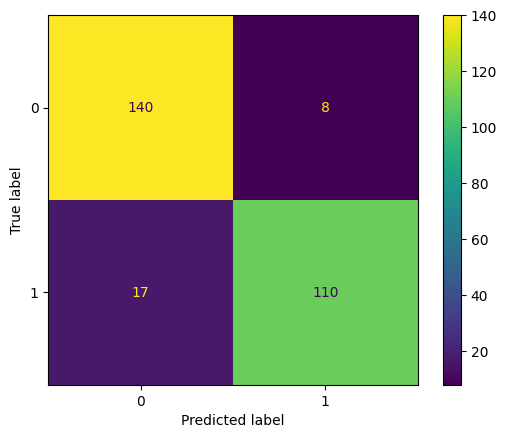

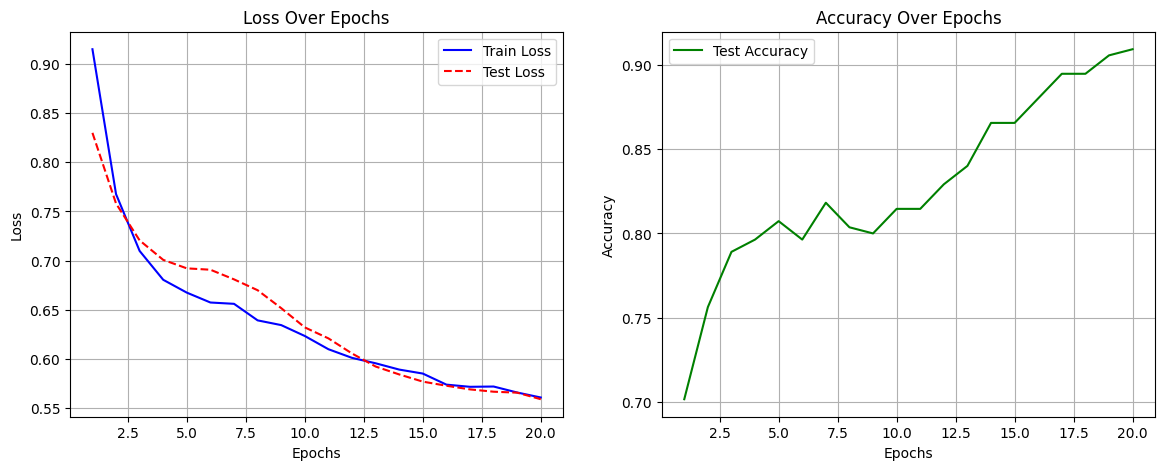

F1 SCORE:  0.8979591836734694  | ACCURACY SCORE:  0.9090909090909091


In [21]:
test_outputs = qnn.forward(X_test, weights)
predicted = np.where(test_outputs > 0, 1, -1).flatten() # Tutaj tez uzywamy np.where

c_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted))
c_matrix_display.plot()

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs, test_loss_history, label='Test Loss', color='red', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Test Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("F1 SCORE: ", f1_score(y_test, predicted), " | ACCURACY SCORE: ", accuracy_score(y_test, predicted))